In [1]:
%cd ../

/home/users/dmoreno2016/ASTROMER/astromer_pe_main/astromer/presentation/experiments/astromer_1_pe


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import glob
import toml
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

In [3]:
pretraining_path = 'results/pretraining/P02R01_clean/exp_001_a'
finetuning_path = 'results/finetuning/P02R01_clean/exp_001_a'

datasets_names = ['alcock', 'atlas', 'ogle']
subsets = [500]
folds = [0, 1, 2]

In [4]:
#datasets_names = ['kepler', 'kepler_alcock_linear', 'kepler_atlas_linear', 'kepler_ogle_linear']
#subsets = ['all']

datasets_names = ['alcock', 'atlas', 'ogle', 'kepler', 'kepler_alcock_linear', 'kepler_atlas_linear', 'kepler_ogle_linear']
subsets = [50]

In [5]:
## Pretraining metrics
dict_logs_pretraining = dict()

for subset_name in subsets:
    if subset_name != 'all':
        path_metrics = os.path.join(pretraining_path, 'test_metrics_datasets_{}.toml'.format(subset_name))
    else:
        path_metrics = os.path.join(pretraining_path, 'test_metrics_datasets.toml')

    with open(path_metrics, 'r') as f:
        dict_logs_pretraining['{}'.format(subset_name)] = toml.load(f)

In [6]:
dict_pt_metrics_normal = {
    'r2': [],
    'rmse': [],
    'time_epoch': [],
    'time_batch': [],
}

In [7]:
for subset in subsets:
    df_r2, df_rmse, df_time_epoch, df_time_batch = [], [], [], []
    for ds_name in datasets_names:            
        
        list_r2, list_rmse, list_time_epoch, list_time_batch = [], [], [], []
        for fold in folds:
            list_r2.append(dict_logs_pretraining['{}'.format(subset)][ds_name]['fold_{}'.format(fold)]['r_square'])
            list_rmse.append(dict_logs_pretraining['{}'.format(subset)][ds_name]['fold_{}'.format(fold)]['rmse'])
            list_time_epoch.append(0)
            list_time_batch.append(0)
            
        df_r2.append(pd.DataFrame({ds_name: list_r2}))
        df_rmse.append(pd.DataFrame({ds_name: list_rmse}))
        df_time_epoch.append(pd.DataFrame({ds_name: list_time_epoch}))
        df_time_batch.append(pd.DataFrame({ds_name: list_time_batch}))

    dict_pt_metrics_normal['r2'] = pd.concat(df_r2, axis=1)
    dict_pt_metrics_normal['rmse'] = pd.concat(df_rmse, axis=1)
    dict_pt_metrics_normal['time_epoch'] = pd.concat(df_time_epoch, axis=1)
    dict_pt_metrics_normal['time_batch'] = pd.concat(df_time_batch, axis=1)

In [8]:
for metric_name, dict_results in dict_pt_metrics_normal.items():
    dict_results['fold'] = folds
    dict_results['Trainable layers'] = ['Without FT' for _ in folds]
    dict_results['lr'] = ['direct' for _ in folds]
    dict_pt_metrics_normal['{}'.format(metric_name)] = dict_results

In [9]:
dict_pt_metrics_normal['r2']

,alcock,atlas,ogle,kepler,kepler_alcock_linear,kepler_atlas_linear,kepler_ogle_linear,fold,Trainable layers,lr
0,0.510042,0.598490,0.611932,-7.254331,0.490498,0.408419,0.468436,0,Without FT,direct
1,0.540565,0.550543,0.621477,-7.263005,0.501423,0.409936,0.484874,1,Without FT,direct
2,0.527168,0.601656,0.606823,-7.169085,0.509424,0.435927,0.485133,2,Without FT,direct


In [10]:
dict_pt_metrics_normal['rmse']

,alcock,atlas,ogle,kepler,kepler_alcock_linear,kepler_atlas_linear,kepler_ogle_linear,fold,Trainable layers,lr
0,0.169175,0.197482,0.141871,0.086840,0.037845,0.041622,0.037927,0,Without FT,direct
1,0.143031,0.197341,0.136870,0.086880,0.038730,0.040834,0.038284,1,Without FT,direct
2,0.162808,0.200292,0.148466,0.086914,0.038040,0.041031,0.037852,2,Without FT,direct


In [11]:
dict_pt_metrics = dict_pt_metrics_normal.copy()

## Extract finetuning metrics

In [12]:
## Finetuning metrics

dict_logs_finetuning = dict()
for path_lr_files in glob.glob('{}/*'.format(finetuning_path)):
    lr = path_lr_files.split('/')[-1]

    dict_logs_finetuning[lr] = dict()
    for path_science_cases in glob.glob('{}/*'.format(path_lr_files)):

        spc = path_science_cases.split('/')[-1]

        #if spc in ['PE']:

        dict_logs_finetuning[lr][spc] = dict()
        for path_ds_name in glob.glob('{}/*'.format(path_science_cases)):
            ds_name = path_ds_name.split('/')[-1]

            if ds_name in datasets_names:

                dict_logs_finetuning[lr][spc][ds_name] = dict()
                for path_fold in glob.glob('{}/*'.format(path_ds_name)):
                    fold_name = path_fold.split('/')[-1]

                    dict_logs_finetuning[lr][spc][ds_name][fold_name] = dict()

                    for path_subsets in glob.glob('{}/*'.format(path_fold)):
                        subset_name = path_subsets.split('/')[-1]
                        #print(subset_name.split('_')[-1])
                        #print(subsets)

                        try:
                            if int(subset_name.split('_')[-1]) in subsets:
                                #print('a')
                            
                                with open(os.path.join(path_subsets, 'test_metrics.toml'), 'r') as f:
                                    metrics = toml.load(f)

                                dict_logs_finetuning[lr][spc][ds_name][fold_name][subset_name] = dict()
                                #for files in ['metrics', 'time_epoch', 'time_batch']:
                                dict_logs_finetuning[lr][spc][ds_name][fold_name][subset_name]['metrics'] = metrics
                                dict_logs_finetuning[lr][spc][ds_name][fold_name][subset_name]['time_batch'] = pd.read_csv(os.path.join(path_subsets, 'time_batch.csv'))
                                dict_logs_finetuning[lr][spc][ds_name][fold_name][subset_name]['time_epoch'] = pd.read_csv(os.path.join(path_subsets, 'time_epoch.csv'))
                        except:
                            pass # por los que tienen un string en la ultima palabra del dataset all
                            #break
                    #break
#                break
#            break
#        break
#    break
           


In [13]:
dict_ft_metrics = dict()

for path_lr_files in glob.glob('{}/*'.format(finetuning_path)):
    lr = path_lr_files.split('/')[-1]
       
    dict_ft_metrics[lr] = {
        'r2': [],
        'rmse': [],
        'time_epoch': [],
        'time_batch': [],
    }

    for subset in subsets:

        for i, idx_name in enumerate(list(dict_logs_finetuning[lr].keys())):

            df_r2, df_rmse, df_time_epoch, df_time_batch = [], [], [], []
            for ds_name in datasets_names:            

                list_r2, list_rmse, list_time_epoch, list_time_batch = [], [], [], []
                for fold in folds:
                    try:

                        if subset != 'all':
                            #print('idx_name: {}'.format(idx_name))
                            #print('dict_logs_finetuning: {}'.format(dict_logs_finetuning))
                            list_r2.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}_{}'.format(ds_name, subset)]['metrics']['r_square'])
                            list_rmse.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}_{}'.format(ds_name, subset)]['metrics']['rmse'])
                            list_time_epoch.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}_{}'.format(ds_name, subset)]['time_epoch'].time_epoch.values.sum())
                            list_time_batch.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}_{}'.format(ds_name, subset)]['time_batch'].time_batch.values.sum())

                        else:
                            list_r2.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}'.format(ds_name)]['metrics']['r_square'])
                            list_rmse.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}'.format(ds_name)]['metrics']['rmse'])
                            list_time_epoch.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}'.format(ds_name)]['time_epoch'].time_epoch.values.sum())
                            list_time_batch.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}'.format(ds_name)]['time_batch'].time_batch.values.sum())

                    except: 
                        print('We do not have fold {} ({})'.format(fold, ds_name))
                        #break
                        
                df_r2.append(pd.DataFrame({ds_name: list_r2}))
                df_rmse.append(pd.DataFrame({ds_name: list_rmse}))
                df_time_epoch.append(pd.DataFrame({ds_name: list_time_epoch}))
                df_time_batch.append(pd.DataFrame({ds_name: list_time_batch}))

            dict_ft_metrics[lr]['r2'].append(pd.concat(df_r2, axis=1))
            dict_ft_metrics[lr]['rmse'].append(pd.concat(df_rmse, axis=1))
            dict_ft_metrics[lr]['time_epoch'].append(pd.concat(df_time_epoch, axis=1))
            dict_ft_metrics[lr]['time_batch'].append(pd.concat(df_time_batch, axis=1))

            for metric_name, dict_results in dict_ft_metrics[lr].items():
                dict_results[i]['fold'] = folds
                dict_results[i]['Trainable layers'] = ['{}'.format(idx_name) for _ in folds]
                dict_ft_metrics[lr]['{}'.format(metric_name)][i] = dict_results[i]
            
        for metric_name, _ in dict_ft_metrics[lr].items():
            dict_ft_metrics[lr][metric_name] = pd.concat(dict_ft_metrics[lr][metric_name])


In [14]:
for path_lr_files in glob.glob('{}/*'.format(finetuning_path)):
    lr = path_lr_files.split('/')[-1]
    
    dict_ft_metrics[lr]['r2']['lr'] = lr # '_'.join(lr.split('_')[:2])
    dict_ft_metrics[lr]['rmse']['lr'] = lr # '_'.join(lr.split('_')[:2])
    dict_ft_metrics[lr]['time_epoch']['lr'] = lr # '_'.join(lr.split('_')[:2])
    dict_ft_metrics[lr]['time_batch']['lr'] = lr # '_'.join(lr.split('_')[:2])

In [15]:
dict_ft_metrics.keys()

dict_keys(['lr_scheduler'])

In [16]:
dict_ft_metrics['lr_scheduler']['r2']

,alcock,atlas,ogle,kepler,kepler_alcock_linear,kepler_atlas_linear,kepler_ogle_linear,fold,Trainable layers,lr
0,0.512030,0.598651,0.615407,-0.975025,0.551316,0.530220,0.549662,0,PE,lr_scheduler
1,0.545125,0.585977,0.623406,-0.882278,0.576643,0.529378,0.482274,1,PE,lr_scheduler
2,0.531260,0.578231,0.606205,-0.347598,0.581812,0.520389,0.548598,2,PE,lr_scheduler


## RMSE v/s Finetuning time

In [17]:
import seaborn as sns

In [18]:
dict_pt_metrics['r2']

,alcock,atlas,ogle,kepler,kepler_alcock_linear,kepler_atlas_linear,kepler_ogle_linear,fold,Trainable layers,lr
0,0.510042,0.598490,0.611932,-7.254331,0.490498,0.408419,0.468436,0,Without FT,direct
1,0.540565,0.550543,0.621477,-7.263005,0.501423,0.409936,0.484874,1,Without FT,direct
2,0.527168,0.601656,0.606823,-7.169085,0.509424,0.435927,0.485133,2,Without FT,direct


In [19]:
dict_ft_metrics_concat = {
            'r2': [],
            'rmse': [],
            'time_epoch': [],
            'time_batch': [],
        }

In [20]:
for key, df_value in dict_ft_metrics.items():
    dict_ft_metrics_concat['r2'].append(df_value['r2'])
    dict_ft_metrics_concat['rmse'].append(df_value['rmse'])
    dict_ft_metrics_concat['time_epoch'].append(df_value['time_epoch'])
    dict_ft_metrics_concat['time_batch'].append(df_value['time_batch'])

dict_ft_metrics_concat['r2'] = pd.concat(dict_ft_metrics_concat['r2'])
dict_ft_metrics_concat['rmse'] = pd.concat(dict_ft_metrics_concat['rmse'])
dict_ft_metrics_concat['time_epoch'] = pd.concat(dict_ft_metrics_concat['time_epoch'])
dict_ft_metrics_concat['time_batch'] = pd.concat(dict_ft_metrics_concat['time_batch'])

In [21]:
dict_ft_metrics_concat['r2']

,alcock,atlas,ogle,kepler,kepler_alcock_linear,kepler_atlas_linear,kepler_ogle_linear,fold,Trainable layers,lr
0,0.512030,0.598651,0.615407,-0.975025,0.551316,0.530220,0.549662,0,PE,lr_scheduler
1,0.545125,0.585977,0.623406,-0.882278,0.576643,0.529378,0.482274,1,PE,lr_scheduler
2,0.531260,0.578231,0.606205,-0.347598,0.581812,0.520389,0.548598,2,PE,lr_scheduler


In [22]:
dict_metrics = dict()
dict_metrics['r2'] = pd.concat([dict_pt_metrics['r2'], dict_ft_metrics_concat['r2']]).reset_index(drop=True)
dict_metrics['rmse'] = pd.concat([dict_pt_metrics['rmse'], dict_ft_metrics_concat['rmse']]).reset_index(drop=True)
dict_metrics['time_epoch'] = pd.concat([dict_pt_metrics['time_epoch'], dict_ft_metrics_concat['time_epoch']]).reset_index(drop=True)
dict_metrics['time_batch'] = pd.concat([dict_pt_metrics['time_batch'], dict_ft_metrics_concat['time_batch']]).reset_index(drop=True)
dict_metrics['r2']

,alcock,atlas,ogle,kepler,kepler_alcock_linear,kepler_atlas_linear,kepler_ogle_linear,fold,Trainable layers,lr
0,0.510042,0.598490,0.611932,-7.254331,0.490498,0.408419,0.468436,0,Without FT,direct
1,0.540565,0.550543,0.621477,-7.263005,0.501423,0.409936,0.484874,1,Without FT,direct
2,0.527168,0.601656,0.606823,-7.169085,0.509424,0.435927,0.485133,2,Without FT,direct
3,0.512030,0.598651,0.615407,-0.975025,0.551316,0.530220,0.549662,0,PE,lr_scheduler
4,0.545125,0.585977,0.623406,-0.882278,0.576643,0.529378,0.482274,1,PE,lr_scheduler
5,0.531260,0.578231,0.606205,-0.347598,0.581812,0.520389,0.548598,2,PE,lr_scheduler


In [23]:
trainable_layers = ['Without FT', 'PE']

In [24]:
dict_results = {
    'Dataset name': [],
    'Trainable layers': [],
    'Learning rate': [],
    'Fold':[],
    'Time training': [],
    'R^2': [],
    'RMSE': [],
}

df_results = []
for dataset_name in datasets_names:
    dict_results['Dataset name'] = np.repeat(dataset_name, len(dict_metrics['r2']))
    dict_results['Trainable layers'] = dict_metrics['r2']['Trainable layers'].values
    dict_results['Learning rate'] = dict_metrics['r2']['lr'].values
    dict_results['Fold'] = dict_metrics['r2']['fold'].values
    dict_results['Time training'] = dict_metrics['time_epoch'][dataset_name].values
    dict_results['R^2'] = dict_metrics['r2'][dataset_name].values
    dict_results['RMSE'] = dict_metrics['rmse'][dataset_name].values
    df_results.append(pd.DataFrame(dict_results))

df_results = pd.concat(df_results).reset_index(drop=True)
df_results

,Dataset name,Trainable layers,Learning rate,Fold,Time training,R^2,RMSE
0,alcock,Without FT,direct,0,0.000000,0.510042,0.169175
1,alcock,Without FT,direct,1,0.000000,0.540565,0.143031
2,alcock,Without FT,direct,2,0.000000,0.527168,0.162808
3,alcock,PE,lr_scheduler,0,45.123446,0.512030,0.167433
4,alcock,PE,lr_scheduler,1,24.876696,0.545125,0.143962
5,alcock,PE,lr_scheduler,2,42.528289,0.531260,0.162810
6,atlas,Without FT,direct,0,0.000000,0.598490,0.197482
7,atlas,Without FT,direct,1,0.000000,0.550543,0.197341
8,atlas,Without FT,direct,2,0.000000,0.601656,0.200292
9,atlas,PE,lr_scheduler,0,35.049463,0.598651,0.196960


In [25]:
def get_r2_positive(df):
  for i, row in df.iterrows():
      if row['R^2'] < 0:
          df.at[i, 'R^2'] = 0
          df.at[i, 'R^2'] = 0
            
  return df

def bar_plot_pt(df, x, y, title):
  # who v/s fare barplot
  ax = sns.barplot(x = x,
                  y = y,
                  data = df).set(title=title)

  #place legend outside top right corner of plot
  #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
  plt.xticks(rotation=45)

  # Show the plot
  plt.show()


#def bar_plot_ft(df, x, y, title):
#  # who v/s fare barplot
#  ax = sns.barplot(x = x,
#                   y = y,
#                   hue = 'Learning rate',
#                   data = df,
#                   errorbar = 'sd').set(title=title)
#
#  #place legend outside top right corner of plot
#  plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#  plt.xticks(rotation=45)
#  
#
#  plt.ylim(-0.5, 1)
#
#  # Iterate through the list of bars (patches) and add text
#  for p in ax.patches:
#      height = p.get_height()
#      # If you encounter a NaN height, you can skip adding text to that bar
#      if not pd.isna(height):
#          ax.text(p.get_x() + p.get_width() / 2., height, f'{height:.2f}', ha='center', va='bottom')
#
#
#
#
#  # Show the plot
#  plt.show()


def bar_plot_ft(df, x, y, title):
    # Create the bar plot and store the returned Axes object in 'ax'
    ax = sns.barplot(x=x, y=y, hue='Learning rate', data=df, errorbar='sd')
    ax.set_title(title)

    # Place legend outside top right corner of plot
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.xticks(rotation=45)
    plt.ylim(-0.5, 1)

    # Iterate through the list of bars (patches) and add text
    for bar in ax.patches:
      if bar.get_height() > 0:

        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 0.03, 
            f'{bar.get_height():.3f}', 
            ha='center', 
            va='bottom'
        )

      else:
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            0.0 + 0.03, 
            f'{bar.get_height():.3f}', 
            ha='center', 
            va='bottom'
        )     

    # Show the plot
    plt.show()

In [26]:
df_results_final = get_r2_positive(df_results.copy())
df_results_final.head()

,Dataset name,Trainable layers,Learning rate,Fold,Time training,R^2,RMSE
0,alcock,Without FT,direct,0,0.000000,0.510042,0.169175
1,alcock,Without FT,direct,1,0.000000,0.540565,0.143031
2,alcock,Without FT,direct,2,0.000000,0.527168,0.162808
3,alcock,PE,lr_scheduler,0,45.123446,0.512030,0.167433
4,alcock,PE,lr_scheduler,1,24.876696,0.545125,0.143962


In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
#learning_rates = ['direct', 'correction']
#
#df_results_pt = df_results[df_results['Learning rate'].isin(learning_rates)]
#
#x = 'Dataset name'
#y = 'R^2'
#title = 'Pretraining evaluated directly in the datasets'.format(subsets[0])
#
#from matplotlib import rcParams
#
## figure size in inches
#rcParams['figure.figsize'] = 16, 9
#rcParams.update({'font.size': 18})
#rcParams['axes.labelpad'] = 14
#
#bar_plot_ft(df_results_pt, x, y, title)

In [29]:
#ds_names = ['alcock', 'atlas', 'ogle', 'kepler', 'kepler_alcock_linear', 'kepler_atlas_linear', 'kepler_ogle_linear']
#ds_names = ['alcock', 'atlas', 'ogle']

In [30]:
df_results_only_PE = df_results[df_results['Trainable layers'].isin(['Without FT', 'PE'])]

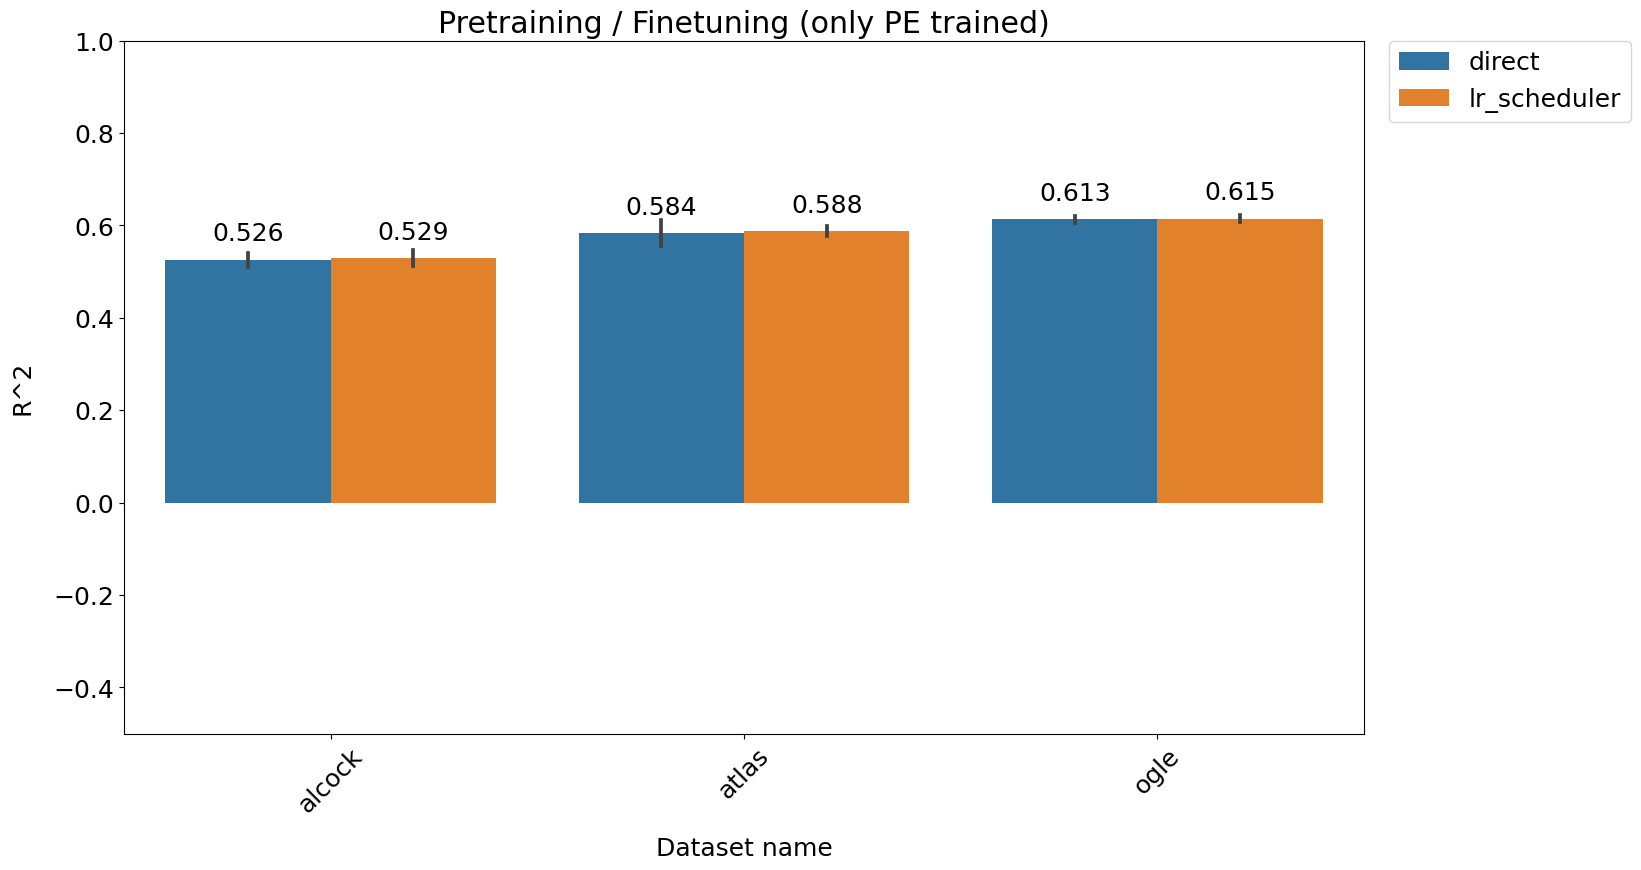

In [31]:
ds_names = ['alcock', 'atlas', 'ogle']

x = 'Dataset name'
y = 'R^2'
title = 'Pretraining / Finetuning (only PE trained)'.format(subsets[0])

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 16, 9
rcParams.update({'font.size': 18})
rcParams['axes.labelpad'] = 14

bar_plot_ft(df_results_only_PE[df_results_only_PE['Dataset name'].isin(ds_names)], x, y, title)

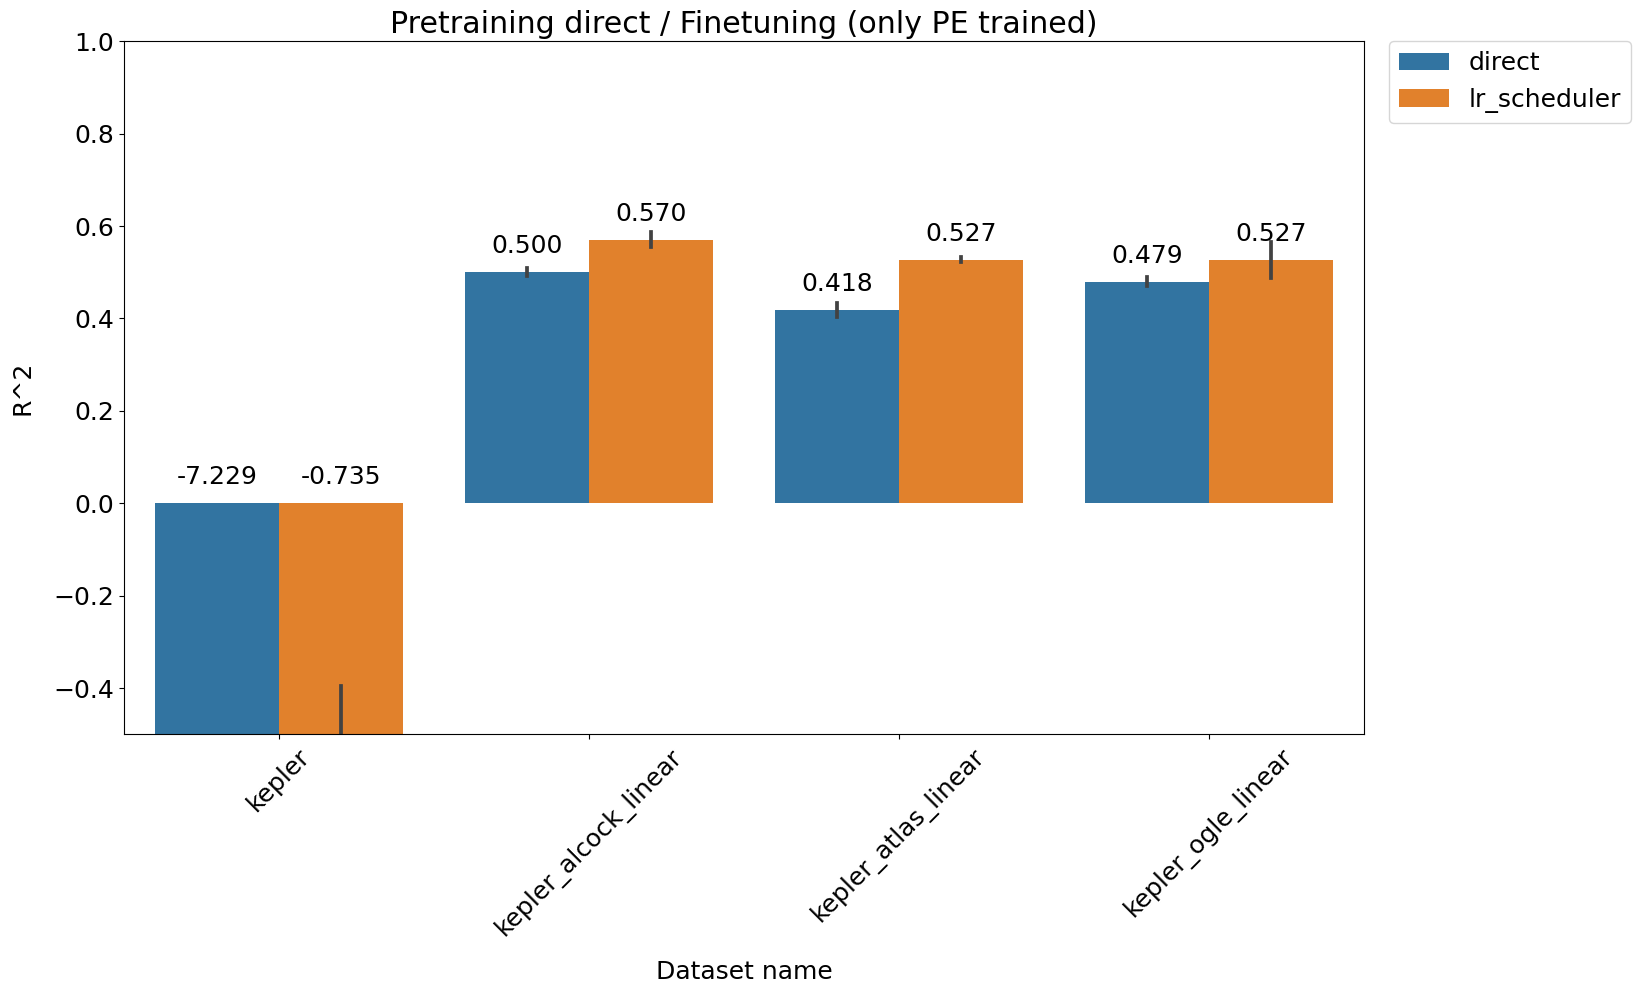

In [32]:
ds_names = ['kepler', 'kepler_alcock_linear', 'kepler_atlas_linear', 'kepler_ogle_linear']

x = 'Dataset name'
y = 'R^2'
title = 'Pretraining direct / Finetuning (only PE trained)'.format(subsets[0])

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 16, 9
rcParams.update({'font.size': 18})
rcParams['axes.labelpad'] = 14

bar_plot_ft(df_results_only_PE[df_results_only_PE['Dataset name'].isin(ds_names)], x, y, title)